In [2]:
import sys
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader
from typing import Union, Tuple

import pickle as pk

from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

In [4]:
torch.cuda.is_available()

True

# Load the MNIST Dataset

In [7]:
#DataPath = r"D:\PatternRecognition_Data"
DataPath = "./"

train_data = datasets.MNIST(DataPath, train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=len(train_data))
batch = next(iter(train_loader))
x, y = batch
mean, std = torch.mean(x), torch.std(x)
transform = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
])

batch_size = 32
trainset = datasets.MNIST(root=DataPath, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.MNIST(root=DataPath, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [6]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 28, 28])

# Exercise 1: Autoencoder Network Implementation

Implement an Autoencoder that encodes the MNIST dataset to a latent dimension of size m < 784. Use Tranposed Convolutions and/or Unpooling to solve this exercise. Train the Autoencoder and plot the reconstruction training loss. Plot 5 digits (of your choice) before and after reconstruction. Do this for two different latent dimension sizes.


In [38]:
class Autoencoder(nn.Module):
  def __init__(self, latent_width):
    # Initialize as subclass of nn.Module inheriting all its functions
    super(Autoencoder, self).__init__()
    encode = [nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
              nn.LeakyReLU(),
              nn.BatchNorm2d(16),
              nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
              nn.LeakyReLU(),
              nn.BatchNorm2d(32)]
    decode = [nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2, padding=0),
              nn.LeakyReLU(),
              nn.BatchNorm2d(16),
              nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2, padding=0),
              nn.LeakyReLU(),
              nn.BatchNorm2d(1)]
    self.encoder = nn.Sequential(*encode)
    self.encoder_end = nn.Linear(32 * 7 * 7, latent_width)
    self.decoder_start = nn.Linear(latent_width, 32 * 7 * 7)
    self.decoder = nn.Sequential(*decode)
                                           

  def forward(self, x):
    print(x.shape)
    z = self.encoder(x)
    print(z.shape)
    z = self.encoder_end(z.reshape([z.shape[0],-1]))
    print(z.shape)
    y = self.decoder_start(z)
    print(y.shape)
    print(y.reshape([y.shape[0],32,7,7]).shape)
    y = self.decoder(y.reshape([y.shape[0],32,7,7]))
    print(y.shape)
    return y

In [39]:
autoenc_model = Autoencoder(latent_width=100)
summary(autoenc_model, input_size=(1, 28, 28), device='cpu')

torch.Size([2, 1, 28, 28])
torch.Size([2, 32, 7, 7])
torch.Size([2, 100])
torch.Size([2, 1568])
torch.Size([2, 32, 7, 7])
torch.Size([2, 1, 28, 28])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
         LeakyReLU-2           [-1, 16, 14, 14]               0
       BatchNorm2d-3           [-1, 16, 14, 14]              32
            Conv2d-4             [-1, 32, 7, 7]           4,640
         LeakyReLU-5             [-1, 32, 7, 7]               0
       BatchNorm2d-6             [-1, 32, 7, 7]              64
            Linear-7                  [-1, 100]         156,900
            Linear-8                 [-1, 1568]         158,368
   ConvTranspose2d-9           [-1, 16, 14, 14]           2,064
        LeakyReLU-10           [-1, 16, 14, 14]               0
      BatchNorm2d-11           [-1, 16, 14, 14]              32
  ConvTranspose2d-

In [9]:
def train(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    data: Union[DataLoader, Tuple[DataLoader]], 
    max_epochs: int, 
    cuda=True):
    """
    Train a NN 'model' on 'data' in 'max_epochs' many epochs using 'optimizer' optimization method.
    """
  
    use_test = False
    if isinstance(data, DataLoader):
        train_loader = data
    elif isinstance(data, tuple):
        if len(data) == 2:
            train_loader, test_loader = data
            if not isinstance(train_loader, DataLoader):
                raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
            if not isinstance(test_loader, DataLoader):
                raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
            use_test = True
        else:
            raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')
  
    criterion = nn.MSELoss()
    model.train()
    losses = []
    batch_total = len(train_loader)

    for epoch in range(max_epochs):
        samples_total = 0
        samples_correct = 0
        for batch_idx, batch in enumerate(train_loader):
            x, y = batch
            if cuda:
                x, y = x.cuda(), y.cuda()
            output = model(x)
            loss = criterion(output, x)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if batch_idx % 50 == 0:
                sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f}')
    return losses

### Train with latent space size 100:

In [12]:
autoenc_model_100 = Autoencoder(latent_width=100)
autoenc_model_100 = autoenc_model_100.cuda()
autoenc_optim_100 = optim.Adam(autoenc_model_100.parameters(), lr=1e-5)
autoenc_losses_100 = train(autoenc_model_100, autoenc_optim_100, (train_loader, test_loader), max_epochs=10)

Epoch: 9/10 Step: 1850/1875 Loss: 0.126405

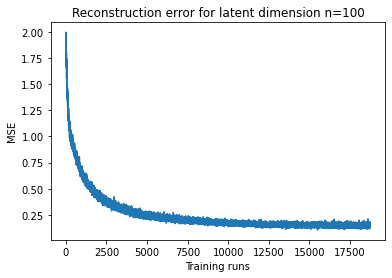

In [14]:
fig, ax = plt.subplots()
ax.plot(autoenc_losses_100)
ax.set_title('Reconstruction error for latent dimension n=100')
ax.set_xlabel('Training runs')
ax.set_ylabel('MSE')
plt.show()

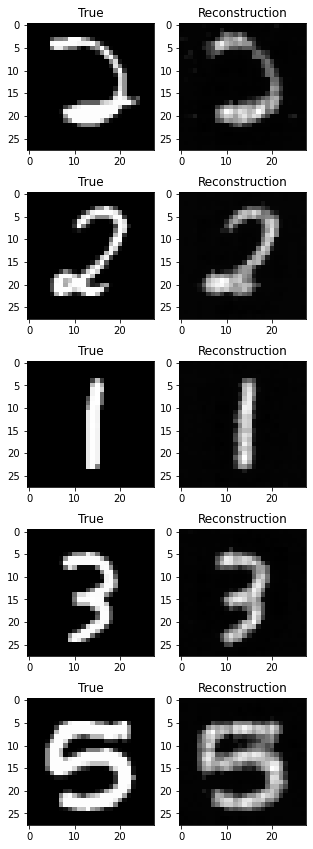

In [ ]:
x, y = next(iter(train_loader))
# img_block = autoenc_model.decoder(torch.rand(32,16,7,7))
img_block = autoenc_model_100(x[:5].cuda())

fig = plt.figure(figsize=(5, 15))
columns = 2
rows = 5
counter = 0
for x, img in zip(x[:5],img_block):
    img_new = img[0].detach().cpu().numpy()
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(x[0], cmap="gray")
    counter += 1
    plt.title("True")
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img_new, cmap="gray")
    plt.title("Reconstruction")
    counter += 1
plt.show()

### Train with latent space size 10:

In [ ]:
autoenc_model_10 = Autoencoder(latent_width=10)

autoenc_model_10 = autoenc_model_10.cuda()

autoenc_optim_10 = optim.Adam(autoenc_model_10.parameters(), lr=1e-5)

autoenc_losses_10 = train(autoenc_model_10, autoenc_optim_10, (train_loader, test_loader), max_epochs=10)

Epoch: 9/10 Step: 1850/1875 Loss: 0.397266

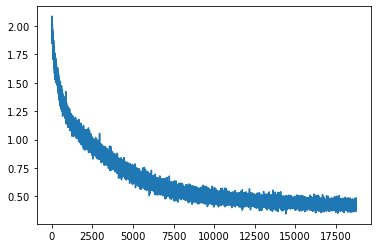

In [ ]:
fig, ax = plt.subplots()
ax.plot(autoenc_losses_10)
ax.set_title('Reconstruction error for latent dimension n=10')
ax.set_xlabel('Training runs')
ax.set_ylabel('MSE')
plt.show()

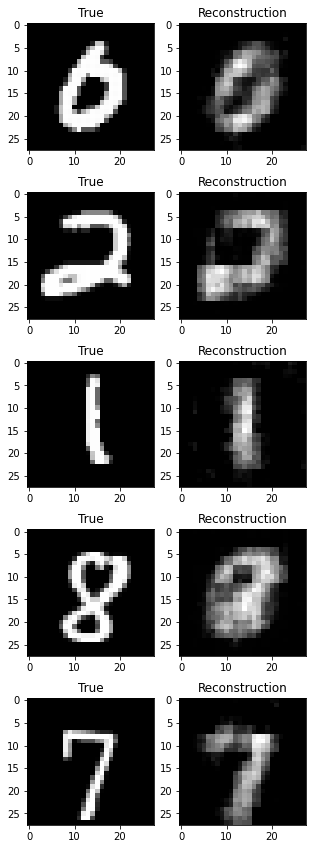

In [ ]:
x, y = next(iter(train_loader))
# img_block = autoenc_model.decoder(torch.rand(32,16,7,7))
img_block = autoenc_model_10(x[:5].cuda())

fig = plt.figure(figsize=(5, 15))
columns = 2
rows = 5
counter = 0
for x, img in zip(x[:5],img_block):
    img_new = img[0].detach().cpu().numpy()
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(x[0], cmap="gray")
    counter += 1
    plt.title("True")
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img_new, cmap="gray")
    plt.title("Reconstruction")
    counter += 1
plt.show()

### Result:
The Autoencoder with a latent space of lower dimension compression showed significantly worse image reconstructions than the Autoencode with a higher dimensional latent space!

# Exercise 2: Variational Autoencoder Network Implementation
Now that you have built an Autoencoder, it is time to implement a Variational Autoencoder. You can use the Autoencoder you trained in the previous exercise and adapt it for this exercise. Do not forget to use the reparametrization trick for sampling from Z-space. (30%)

(a) Train a Variational Autoencoder with latent dimension of size 2. Then, plot the digits where their associated position was in latent space similarly as explained in the lecture. (25%)

(b) Plot the variance vector of the decoder for a single input as an image (in digit space; [3,28,28]). What is the interpretation of that? (25%)


In [119]:

class VAE(nn.Module):
  def __init__(self, latent_width):
    # Initialize as subclass of nn.Module inheriting all its functions
    super(VAE, self).__init__()
    encode = [nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
              nn.LeakyReLU(),
              nn.BatchNorm2d(16),
              nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
              nn.LeakyReLU(),
              nn.BatchNorm2d(32)]
    decode = [nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2, padding=0),
              nn.LeakyReLU(),
              nn.BatchNorm2d(16),
              nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2, padding=0),
              nn.LeakyReLU(),
              nn.BatchNorm2d(1)]
    self.encoder = nn.Sequential(*encode)
    self.encoder_end_mu = nn.Linear(32 * 7 * 7, latent_width)
    self.encoder_end_std = nn.Linear(32 * 7 * 7, latent_width)
    self.decoder_start = nn.Linear(latent_width, 32 * 7 * 7)
    self.decoder = nn.Sequential(*decode)
                                           
  def reparametrize(self, mu, std):
     """
     :param mu: mean from the encoder's latent space
     :param std: standard devitation from the encoder's latent space
     """
     # Sample eps from normal distribution: `randn_like` as we need the same size
     eps = torch.randn_like(std) 
     # Sampling as if z was coming from the input space
     return mu + (eps * std) 


  def forward(self, x):
    # Encode
    z = self.encoder(x)
    mu = self.encoder_end_mu(z.reshape([z.shape[0],-1]))
    std = self.encoder_end_std(z.reshape([z.shape[0],-1]))
    # Reparametrization
    z = self.reparametrize(mu, std)
    # Decode
    y = self.decoder_start(z)
    y = self.decoder(y.reshape([-1,32,7,7]))
    return y, mu, std

In [120]:
vae_model = VAE(latent_width=2)
summary(vae_model, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
         LeakyReLU-2           [-1, 16, 14, 14]               0
       BatchNorm2d-3           [-1, 16, 14, 14]              32
            Conv2d-4             [-1, 32, 7, 7]           4,640
         LeakyReLU-5             [-1, 32, 7, 7]               0
       BatchNorm2d-6             [-1, 32, 7, 7]              64
            Linear-7                    [-1, 2]           3,138
            Linear-8                    [-1, 2]           3,138
            Linear-9                 [-1, 1568]           4,704
  ConvTranspose2d-10           [-1, 16, 14, 14]           2,064
        LeakyReLU-11           [-1, 16, 14, 14]               0
      BatchNorm2d-12           [-1, 16, 14, 14]              32
  ConvTranspose2d-13            [-1, 1, 28, 28]              65
        LeakyReLU-14            [-1, 1,

In [133]:
def loss_function(xhat, x, mu, std):
  """
  Implements reconstruction loss and KL divergence
  """
  MSE = F.mse_loss(xhat, x)
  KLD = -0.5 * torch.sum(1+torch.log(torch.pow(std,2))-torch.pow(mu, 2)-torch.pow(std,2))
  return MSE + KLD


def train(model: nn.Module, optimizer: optim.Optimizer, data: Union[DataLoader, Tuple[DataLoader]], max_epochs: int, cuda=True):
    """
    Train a NN 'model' on 'data' in 'max_epochs' many epochs using 'optimizer' optimization method.
    """
  
    use_test = False
    if isinstance(data, DataLoader):
        train_loader = data
    elif isinstance(data, tuple):
        if len(data) == 2:
            train_loader, test_loader = data
            if not isinstance(train_loader, DataLoader):
                raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
            if not isinstance(test_loader, DataLoader):
                raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
            use_test = True
        else:
            raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')
  
    model.train()
    losses = []
    batch_total = len(train_loader)

    for epoch in range(max_epochs):
        samples_total = 0
        samples_correct = 0
        for batch_idx, batch in enumerate(train_loader):
            x, y = batch
            if cuda:
                x, y = x.cuda(), y.cuda()
            xhat, mu, std = model(x)
            #print(xhat.shape, x.shape)
            loss = loss_function(xhat, x, mu, std)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()


            if batch_idx % 50 == 0:
                sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f}')
    return losses

In [134]:
vae_model = VAE(latent_width=2)
vae_model.cuda()
vae_optim = optim.Adam(vae_model.parameters(), lr=1e-3)
vae_losses = train(vae_model, vae_optim, (train_loader, test_loader), max_epochs=5)

Epoch: 4/5 Step: 1850/1875 Loss: 461470.406250

# Issues:
- the reconstruction error increases quite strongly

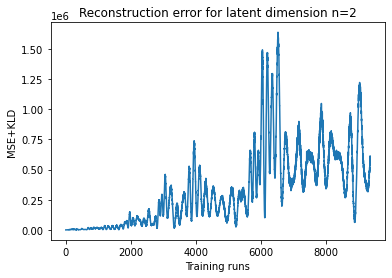

In [135]:
fig, ax = plt.subplots()
ax.plot(vae_losses)
ax.set_title('Reconstruction error for latent dimension n=2')
ax.set_xlabel('Training runs')
ax.set_ylabel('MSE+KLD')
plt.show()